In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import fastf1
from src.plotset import setup_plot
from fastf1 import plotting
import statsmodels.api as sm

setup_plot()

Matplotlib rcParams initialized with custom style.


In [2]:
fastf1.Cache.enable_cache('./f1_cache')
fastf1.Cache.get_cache_info()

('./f1_cache', 2875601580)

In [3]:
session = fastf1.get_session(2025,13,'R')
session.load()

core           INFO 	Loading data for Belgian Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Fixed incorrect tyre stint information for driver '81'
core        WARNING 	Fixed incorrect tyre stint information for driver '4'
core        WARNING 	Fixed incorrect tyre stint information for driver '16'
core        WARNING 	Fixed incorrect tyre stint information for driver '1'
core        WARNING 	Fixed incorrect tyre stint information for driver '63'
core        WARNING 	Fixed incorrect tyre stint information for driver '23'
core        WA

In [4]:
drivers = session.drivers[:10]

In [5]:
total_laps = 44
race_dict = {}
for driver_number in drivers:
    df = session.laps.pick_drivers(driver_number)
    inter_laps = df[df.Compound == 'INTERMEDIATE'].Compound.count()

    df_tel_wet = df.pick_laps([i for i in range(1,inter_laps+1)]).pick_fastest().get_car_data()
    throt_wet = (df_tel_wet.Throttle >= 95).sum()/df_tel_wet.shape[0]

    df_tel_dry = df.pick_laps([i for i in range(inter_laps+1,total_laps+1)]).pick_fastest().get_car_data()
    throt_dry = (df_tel_dry.Throttle >= 95).sum()/df_tel_dry.shape[0]

    race_dict[session.get_driver(driver_number).Abbreviation] = [inter_laps, total_laps - inter_laps, throt_wet, throt_dry]

In [6]:
race_df = pd.DataFrame(race_dict).T.set_axis(['WetLaps','DryLaps','WetThrottle%','DryThrottle%'],axis=1)

In [ ]:
race_df

In [7]:
race_df.mean()

WetLaps         11.900000
DryLaps         32.100000
WetThrottle%     0.485110
DryThrottle%     0.615559
dtype: float64

In [8]:
sc_laps = 4
wet_laps = 12
dry_laps = 32
margin_laps = 5

sc_fuel_cons = 1
dry_fuel_cons = 2.4
wet_by_dry = 0.485/0.616
wet_fuel_cons = round(dry_fuel_cons * wet_by_dry,1)

In [9]:
avg_fuel_cons = sc_laps * sc_fuel_cons + (wet_laps - sc_laps) * wet_fuel_cons + dry_laps * dry_fuel_cons
est_fuel_load = avg_fuel_cons + margin_laps * dry_fuel_cons
est_fuel_load

108.0

In [39]:
def tire_deg(driver_number,nlaps):
    df = session.laps.pick_drivers(driver_number)[['LapNumber','LapTime','Compound','TyreLife']].pick_quicklaps().copy()
    df['LapTime'] = df['LapTime'].dt.total_seconds()
    df['FC_LapTime'] = df['LapTime'] - round((44 - df['LapNumber'])*dry_fuel_cons*0.035,2)

    x = df.iloc[nlaps:].TyreLife
    x = sm.add_constant(x)
    y = df.iloc[nlaps:].FC_LapTime

    model = sm.OLS(y, x).fit()
    return df.iloc[nlaps:], model

Matplotlib rcParams initialized with custom style.


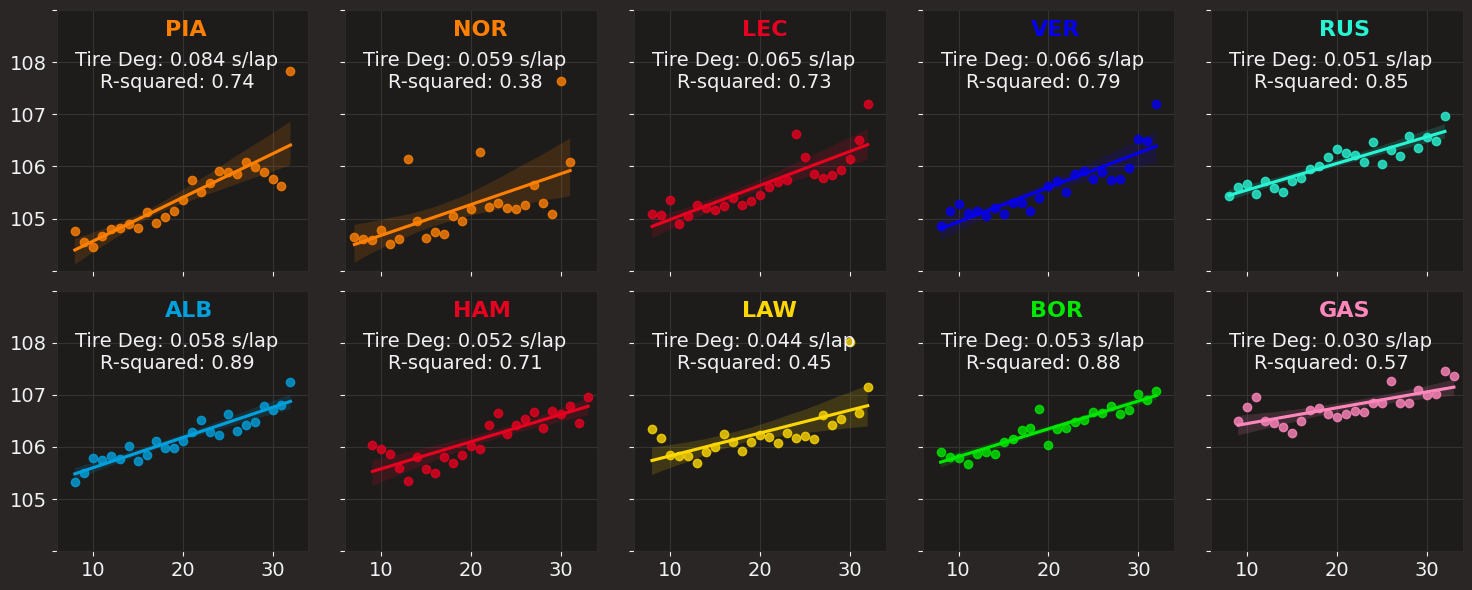

In [147]:
setup_plot()
fig, ax = plt.subplots(2,5,figsize=(15,6),sharex=True,sharey=True)

tires_dict = {}

dc = 0
i = 0
while i <= 1:
    j = 0
    while j <= 4:

        dc += 1
        driver_number = drivers[dc-1]
        dabb = session.get_driver(driver_number).Abbreviation
        df, m = tire_deg(driver_number,-25)
        color = plotting.get_driver_color(identifier=dabb,session=session)
        td, r2, icpt = m.params['TyreLife'], m.rsquared, m.params['const']

        tires_dict[dabb] = [icpt, td, r2, color]

        sns.regplot(x=df.TyreLife,y=df.FC_LapTime,ax=ax[i][j],color=color)
        ax[i][j].set_ylim(104,109)
        ax[i][j].set_yticks([104,105,106,107,108,109])
        ax[i][j].set_yticklabels(['',105,106,107,108,''])
        ax[i][j].set_xlim(6,34)
        ax[i][j].set_xlabel('')
        ax[i][j].set_ylabel('')
        ax[i][j].text(18,108.5,dabb,color=color,fontsize=16,fontweight='bold')
        ax[i][j].text(8,107.5,f'Tire Deg: {m.params['TyreLife']:0.3f} s/lap\n    R-squared: {m.rsquared:0.2f}',fontsize=14)

        j+=1
    i+=1


plt.show()

In [53]:
tires_df = pd.DataFrame(tires_dict).T.set_axis(['intercept','slope','r2','color'],axis=1)

In [105]:
tires_df.loc['NOR','color'] = "yellow"
tires_df.loc['LAW','color'] = "#333333"
tires_df.loc['HAM','color'] = "brown"

In [148]:
from matplotlib import rcParams
# Font sizes
rcParams['xtick.labelsize'] = 18
rcParams['ytick.labelsize'] = 18
# rcParams['axes.labelsize'] = 16
# rcParams['axes.titlesize'] = 24
rcParams['legend.fontsize'] = 20
rcParams['legend.title_fontsize'] = 24

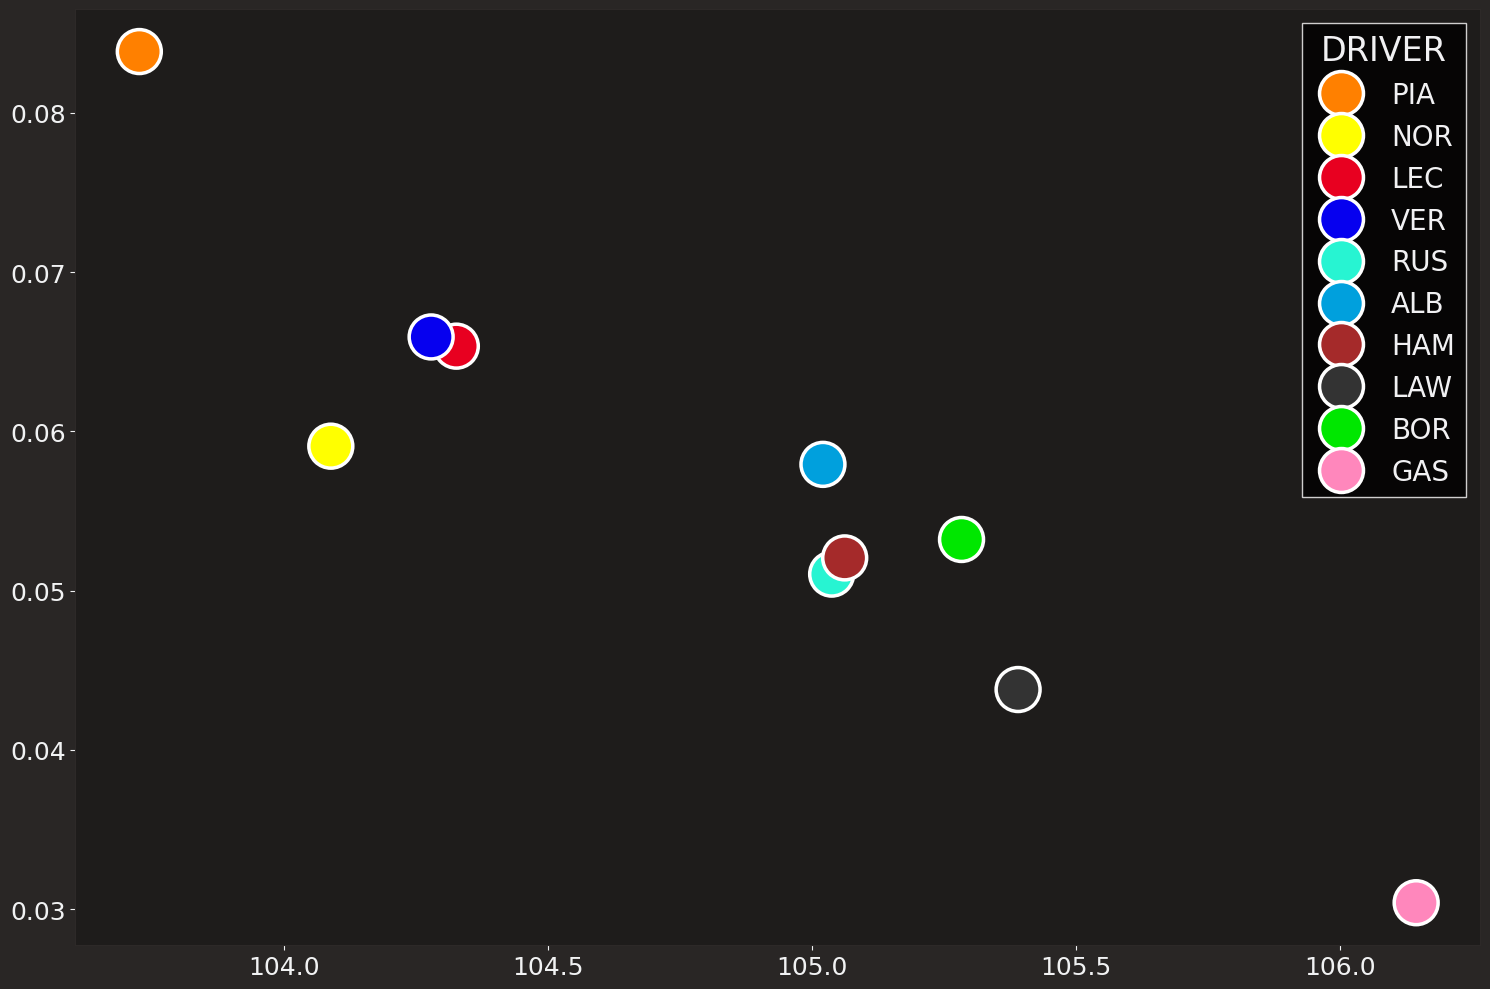

In [151]:
fig, ax = plt.subplots(figsize=(15,10))
sns.scatterplot(data=tires_df,x='intercept',y='slope',hue=tires_df.index,palette=tires_df.color.values.tolist(),s=1000,ax=ax)
ax.set_ylabel('')
ax.set_xlabel('')
ax.legend(title='DRIVER',fontsize=20)
ax.grid(visible=False)

plt.show()

In [85]:
tires_df['StintTime'] = tires_df.apply(lambda x: 25*x['intercept'] + (25*13)*x['slope'],axis=1)

In [86]:
tires_df

,intercept,slope,r2,color,StintTime
PIA,103.726302,0.083857,0.738917,#ff8000,2620.411038
NOR,104.089033,0.059076,0.377465,#ff8000,2621.425577
LEC,104.326742,0.065357,0.733581,#e80020,2629.409538
VER,104.279052,0.065935,0.787746,#0600ef,2628.405308
RUS,105.037698,0.051043,0.848459,#27f4d2,2642.531462
ALB,105.021203,0.057934,0.886656,#00a0dd,2644.358577
HAM,105.062364,0.052061,0.710605,#e80020,2643.478846
LAW,105.390828,0.043795,0.452303,#fcd700,2649.003942
BOR,105.283686,0.053218,0.878275,#00e700,2649.387904
GAS,106.144815,0.030407,0.566192,#ff87bc,2663.502615


In [ ]:
print(m.summary()) 

                            OLS Regression Results                            
Dep. Variable:             FC_LapTime   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     30.02
Date:                Tue, 29 Jul 2025   Prob (F-statistic):           1.43e-05
Time:                        20:08:13   Log-Likelihood:                 5.7923
No. Observations:                  25   AIC:                            -7.585
Df Residuals:                      23   BIC:                            -5.147
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        106.1448      0.123    861.390      0.0